## Subcategory SVM

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from  sklearn import svm as sksvm
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.svm
import numpy as np
import datasets
import joblib
import dotenv
import json
import os


In [2]:
dotenv.load_dotenv()
HF_TOKEN = os.environ['HF_TOKEN']
DATASET_LINK = os.environ['DATASET_LINK']
SEED = 42
TRAINING = True
datasetTotal = datasets.load_dataset(DATASET_LINK, token=HF_TOKEN)

In [3]:
valSet = pd.DataFrame(datasetTotal['validation'])[['subcategory', 'label', 'category','type']]
trainSet = pd.DataFrame(datasetTotal['train'])[['subcategory', 'label', 'category', 'type']]

In [5]:
subcatTrain = set(trainSet['subcategory'])
subcatVal = set(valSet['subcategory'])

subcat = subcatTrain.union(subcatVal)
print(len(subcat))
aliasesSub = {k:i for i,k in enumerate(subcat)}
print(aliasesSub)

catTrain = set(trainSet['category'])
catVal = set(valSet['category'])

cat = catTrain.union(catVal)
print(len(cat))

aliasesCat = {k:i for i,k in enumerate(cat)}
print(aliasesCat)

typeTrain = set(trainSet['type'])
typeVal = set(valSet['type'])

typeTot = typeTrain.union(typeVal)
aliasesType = {k:i for i,k in enumerate(typeTot)}
print(len(typeTot))
print(aliasesType)
aliasLabel = {
    'cultural exclusive':0,
    'cultural agnostic':1,
    'cultural representative':2
}


112
{'folk dance': 0, 'theatrical director': 1, 'greeting': 2, 'transport company': 3, 'transport': 4, 'literary genre': 5, 'animation studio': 6, 'organism': 7, 'textile': 8, 'government agency': 9, 'mode of transport': 10, 'athlete': 11, 'record label': 12, 'fish': 13, 'government': 14, 'food': 15, 'construction': 16, 'religion': 17, 'environment': 18, 'music festival': 19, 'film studio': 20, 'law': 21, 'policy': 22, 'musical profession': 23, 'book': 24, 'plant': 25, 'poet': 26, 'literary award': 27, 'media company': 28, 'art gallery': 29, 'religious movement': 30, 'tree': 31, 'architectural style': 32, 'writing style': 33, 'non-fiction writer': 34, 'television': 35, 'monument': 36, 'acting style': 37, 'architectural structure': 38, 'station': 39, 'sports team': 40, 'film': 41, 'designer': 42, 'art movement': 43, 'architect': 44, 'museum': 45, 'music genre': 46, 'theatrical genre': 47, 'historian': 48, 'visual arts': 49, 'sport': 50, 'cooking technique': 51, 'ingredient': 52, 'ritual

In [ ]:
# Backup the encodings
if False:
    aliasesList = [aliasesCat, aliasesSub, aliasesType, aliasLabel]
    for n,i in enumerate(['categories', 'subcategories', 'types', 'labels']):
        with open(f'{i}Aliases.json', 'w+') as file:
            json.dump(aliasesList[n], file)

In [6]:
subCategoryEncodingTrain = np.zeros((trainSet.shape[0], len(subcat)), dtype=int)
categoryEncodingTrain = np.zeros((trainSet.shape[0], len(cat)), dtype=int)
typeEncodingTrain = np.zeros((trainSet.shape[0], len(typeTot)), dtype=int)

finalTrainLabel = trainSet['label'].apply(lambda x: aliasLabel[x])

for i in range(trainSet.shape[0]):
    subCategoryEncodingTrain[i][aliasesSub[trainSet['subcategory'].iloc[i]]] = 1
    categoryEncodingTrain[i][aliasesCat[trainSet['category'].iloc[i]]] = 1
    typeEncodingTrain[i][aliasesType[trainSet['type'].iloc[i]]] = 1
    
finalTrainData = np.concatenate((subCategoryEncodingTrain, categoryEncodingTrain, typeEncodingTrain), axis=1)
print(finalTrainData.shape)

(6251, 133)


In [7]:
subCategoryEncodingVal = np.zeros((valSet.shape[0], len(subcat)), dtype=int)
categoryEncodingVal = np.zeros((valSet.shape[0], len(cat)), dtype=int)
typeEncodingVal = np.zeros((valSet.shape[0], len(typeTot)), dtype=int)

finalValLabel = valSet['label'].apply(lambda x: aliasLabel[x])

for i in range(valSet.shape[0]):
    try:
        subCategoryEncodingVal[i][aliasesSub[valSet['subcategory'].iloc[i]]] = 1
    except KeyError as e:
        pass
    try:
        categoryEncodingVal[i][aliasesCat[valSet['category'].iloc[i]]] = 1
    except KeyError as e:
        pass
    try:
        typeEncodingVal[i][aliasesType[valSet['type'].iloc[i]]] = 1
    except KeyError as e:
        pass
finalValData = np.concatenate((subCategoryEncodingVal, categoryEncodingVal, typeEncodingVal), axis=1)
print(finalValData.shape)

(300, 133)


In [ ]:
def trainPass(scale: float, 
              gamma: float, 
              kernel: str, 
              features: np.ndarray, 
              labels: np.ndarray, 
              validation_features: np.ndarray, 
              validation_labels: np.ndarray
              )->tuple[float, sklearn.svm.SVC]:
    modelSubcategory = sksvm.SVC(kernel=kernel, 
                                C=scale, 
                                gamma=gamma,
                                class_weight={
                                        2:0.2700,
                                        1:0.2994,
                                        0:0.4305
                                    }, 
                                probability=True, 
                                random_state=SEED,
                                max_iter=10000)
    modelSubcategory.fit(features, labels)
    accuracy_score = modelSubcategory.score(validation_features, validation_labels)
    return accuracy_score, modelSubcategory

In [9]:
# if TRAINING:
#     bestScore = 0
#     bestModel = None
#     for k in ['rbf']:
#         for s in np.linspace(1,1,1):
#             for c in np.linspace(10,10,1):
#                 scoreValidation, model =  trainPass(c,s,k,
#                                           finalTrainData,
#                                           finalTrainLabel,
#                                           finalValData,
#                                           finalValLabel)
#                 if scoreValidation > bestScore:
#                     bestModel = model
#                     bestScore = scoreValidation
#                 print(f'Kernel: {k}, C: {c:.4f}, Gamma: {s:.4f} -> {scoreValidation}')
#     print(f"Accurecy: {bestScore*100:.4f}")
#     print(bestModel)

if TRAINING:
    score, bestModel = trainPass(10,1,'rbf',
                                 finalTrainData,
                                 finalTrainLabel,
                                 finalValData,
                                 finalValLabel)
    
    print(f"Accuracy: {score*100:.4f}%")            

Accuracy: 59.3333%


Best model: kernel='rbf', C=10, gamma=1

In [10]:
if TRAINING:
    joblib.dump(bestModel, 'categorySVCWeights.pkl')

In [11]:
if not TRAINING:
    svm = joblib.load('categorySVCWeights.pkl')
else:
    svm = bestModel
    
results = svm.predict_proba(finalValData)
confidence = results[np.arange(results.shape[0]), np.argmax(results, axis=1)]*100

print(f'Max confidence: {confidence.max():.4f}%')
print(f'Min confidence: {confidence.min():.4f}%')
print(f'Mean confidence: {confidence.mean():.4f}%')
print(f'Std confidence: {confidence.std():.4f}%')

Max confidence: 71.5174%
Min confidence: 38.2382%
Mean confidence: 64.8531%
Std confidence: 6.3313%


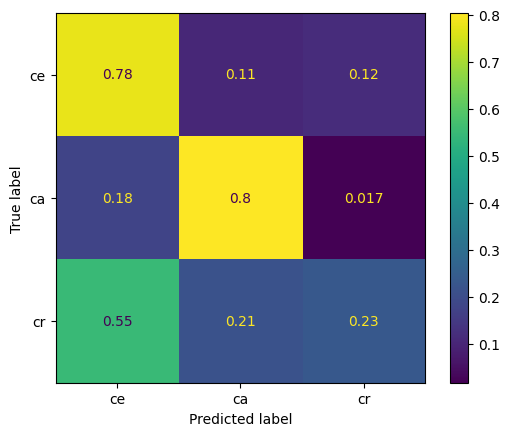

In [12]:
predictions = svm.predict(finalValData)

cfm = confusion_matrix(y_true=finalValLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()

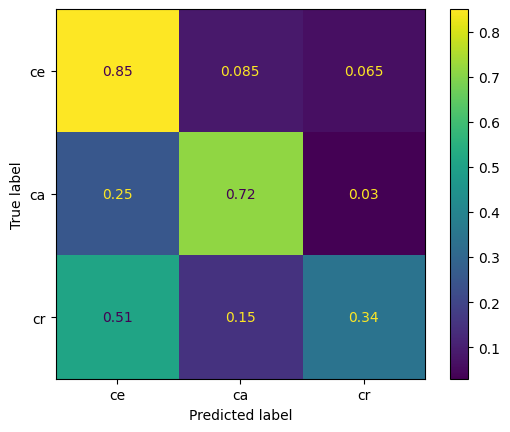

In [13]:
predictions = svm.predict(finalTrainData)

cfm = confusion_matrix(y_true=finalTrainLabel, y_pred=predictions, labels=[0,1,2], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['ce', 'ca', 'cr'])
disp.plot()
plt.show()